# Bayesian Poops 

In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install imageio
# !pip install scipy
# !pip install pymc
# !pip install pingouin

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import imageio
from io import BytesIO

from scipy.special import i0
from typing import Dict, Union, List, Tuple, Optional
import numpy.typing as npt

import pymc as pm
import arviz as az
import arviz.data.inference_data as InferenceData
from scipy.stats import halfnorm, gaussian_kde

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pingouin import (
    convert_angles, circ_rayleigh, circ_vtest,
    circ_mean
)
from scipy.stats import vonmises

In [4]:
data = pd.read_csv('../data/processed/compass_degrees.csv', index_col=0)

In [5]:
data

,image_path,degrees
0,../data/raw/IMG_4514.PNG,157.0
1,../data/raw/IMG_4272.PNG,168.0
2,../data/raw/IMG_4312.PNG,16.0
3,../data/raw/IMG_4448.PNG,281.0
4,../data/raw/IMG_4449.PNG,322.0
...,...,...
148,../data/raw/IMG_6876.PNG,150.0
149,../data/raw/IMG_6877.PNG,151.0
150,../data/raw/IMG_6864.PNG,189.0
151,../data/raw/IMG_6939.PNG,183.0


In [6]:
data['radians'] = convert_angles(data['degrees'], low=0, high=360)

In [7]:
def vonmises_kde(data: np.ndarray, kappa: float, n_bins: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """
    Estimate a von Mises kernel density estimate (KDE) over circular data using scipy.
    
    Parameters:
    - data: np.ndarray -- The input data in radians, expected to be a 1D array.
    - kappa: float -- The concentration parameter for the von Mises distribution.
    - n_bins: int -- The number of bins for the KDE estimate (default is 100).
    
    Returns:
    - bins: np.ndarray -- The bin edges (x-values) used for the KDE.
    - kde: np.ndarray -- The estimated density values (y-values) for each bin.
    """
    bins = np.linspace(-np.pi, np.pi, n_bins)
    kde = np.zeros(n_bins)
    
    for angle in data:
        kde += vonmises.pdf(bins, kappa, loc=angle)
    
    kde = kde / len(data)
    return bins, kde

In [8]:
def plot_circular_distribution(
    data: pd.DataFrame,
    plot_type: str = 'kde',
    bins: int = 30,
    figsize: tuple = (4, 4),
    **kwargs
) -> None:
    """
    Plot a compass rose with either KDE or histogram for circular data.
    
    Parameters:
    -----------
    data: pd.DataFrame
        DataFrame containing 'degrees'and 'radians' columns with circular data
    plot_type: str
        Type of plot to create: 'kde' or 'histogram'
    bins: int
        Number of bins for histogram or smoothing parameter for KDE
    figsize: tuple
        Figure size as (width, height)
    **kwargs: dict
        Additional styling arguments for histogram (color, edgecolor, etc.)
    """
    plt.figure(figsize=figsize)
    ax = plt.subplot(111, projection='polar')

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    # add cardinal directions
    directions = ['N', 'E', 'S', 'W']
    angles = [0, np.pi / 2, np.pi, 3 * np.pi / 2]
    for direction, angle in zip(directions, angles):
        ax.text(
            angle, 0.45, direction,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=12,
            weight='bold'
        )

    if plot_type.lower() == 'kde':
        x, kde = vonmises_kde(data['radians'].values, bins)
        ax.plot(x, kde, color=kwargs.get('color', 'red'), lw=2)
    
    elif plot_type.lower() == 'histogram':
        hist_kwargs = {
            'color': 'teal',
            'edgecolor': 'black',
            'alpha': 0.7
        }
        hist_kwargs.update(kwargs) 
        
        angles_rad = np.deg2rad(data['degrees'].values)
        counts, bin_edges = np.histogram(
            angles_rad, 
            bins=bins, 
            range=(0, 2*np.pi), 
            density=True
        )
        widths = np.diff(bin_edges)
        ax.bar(
            bin_edges[:-1],
            counts,
            width=widths,
            align='edge',
            **hist_kwargs
        )
    
    else:
        raise ValueError("plot_type must be either 'kde' or 'histogram'")
    
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.set_yticklabels([])  # Hide radial ticks
    
    plt.show()

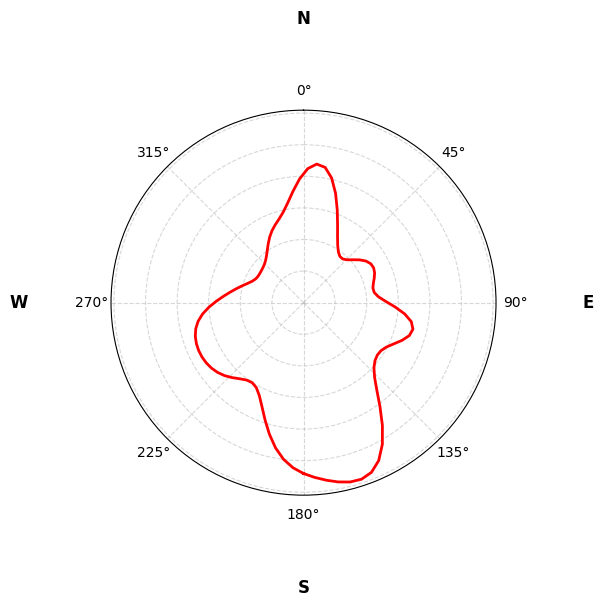

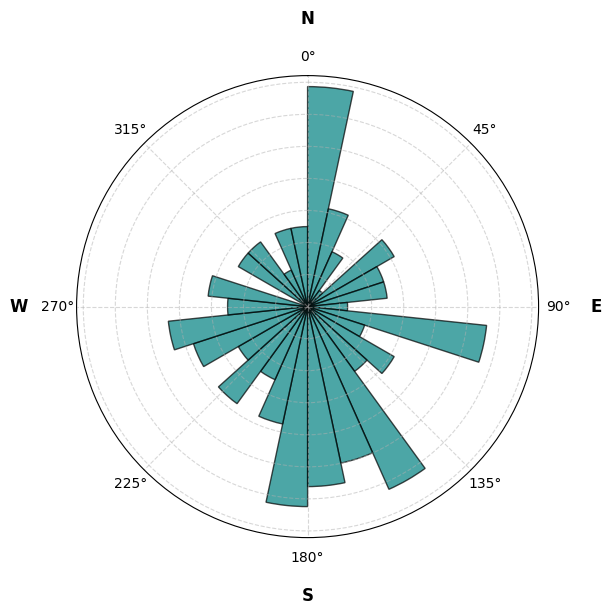

In [9]:
plot_circular_distribution(data, plot_type='kde', figsize=(5, 5))
plot_circular_distribution(data, plot_type='histogram', figsize=(6, 6))

# Statistical testing

In [11]:
z, pval = circ_rayleigh(data['radians'])
print(f"Z-statistics: {z:.3f}; p-value: {pval:.6f}")

Z-statistics: 3.893; p-value: 0.020128


In [12]:
v, pval = circ_vtest(data['radians'], dir=np.pi)
print(f"V-statistics: {v:.3f}; p-value: {pval:.6f}")

V-statistics: 24.127; p-value: 0.002904


In [13]:
arithmetic_mean = data['radians'].mean()
circular_mean = circ_mean(data['radians'])

print(f"Arithmetic mean: {arithmetic_mean:.3f}; Circular mean: {circular_mean:.3f}")

Arithmetic mean: 0.082; Circular mean: 2.990


# Bayesian approach

In [14]:
def get_posterior_distribution_image_array(
    mu_grid: np.ndarray, 
    posterior_pdf: np.ndarray, 
    current_samples: List[float], 
    idx: int, 
    fig_size: Tuple[int, int], 
    dpi: int, 
    r_max_posterior: float
) -> np.ndarray:
    """
    Creates the posterior distribution and observed samples histogram on a polar plot, 
    converts it to an image array, and returns it for GIF processing.

    Args:
        mu_grid (np.ndarray): Grid of mean direction values for plotting the posterior PDF.
        posterior_pdf (np.ndarray): Posterior probability density function values for the given `mu_grid`.
        current_samples (List[float]): List of observed angle samples in radians.
        idx (int): The current step index, used for labeling the plot.
        fig_size (Tuple[int, int]): Size of the plot figure (width, height).
        dpi (int): Dots per inch (resolution) for the plot.
        r_max_posterior (float): Maximum radius for the posterior PDF plot, used to set plot limits.

    Returns:
        np.ndarray: Image array of the plot in RGB format, suitable for GIF processing.
    """
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    ax = plt.subplot(1, 1, 1, projection='polar')
    ax.set_theta_zero_location('N')  
    ax.set_theta_direction(-1)  
    ax.plot(mu_grid, posterior_pdf, color='red', linewidth=2, label='Posterior PDF')

    # observed samples histogram
    n_bins = 48
    hist_bins = np.linspace(-np.pi, np.pi, n_bins + 1)
    hist_counts, _ = np.histogram(current_samples, bins=hist_bins)

    # normalize the histogram counts
    if np.max(hist_counts) > 0:
        hist_counts_normalized = hist_counts / np.max(hist_counts)
    else:
        hist_counts_normalized = hist_counts

    bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
    bin_width = hist_bins[1] - hist_bins[0]

    # set the maximum radius to accommodate both the posterior pdf and histogram bars
    r_histogram_height = r_max_posterior * 0.9 
    r_max = r_max_posterior + r_histogram_height
    ax.set_ylim(0, r_max)

    # plot the histogram bars outside the circle
    for i in range(len(hist_counts_normalized)):
        theta = bin_centers[i]
        width = bin_width
        hist_height = hist_counts_normalized[i] * r_histogram_height
        if hist_counts_normalized[i] > 0:
            ax.bar(
                theta, hist_height, width=width, bottom=r_max_posterior, 
                color='teal', edgecolor='black', alpha=0.5
            )

    ax.text(
        0.5, 1.1, f'Posterior Distribution (Step {idx + 1})', 
        transform=ax.transAxes, ha='center', va='bottom', fontsize=18
    )
    ax.set_yticklabels([])
    ax.grid(linestyle='--')
    ax.yaxis.set_visible(False)
    ax.spines['polar'].set_visible(False)
    plt.subplots_adjust(top=0.85, bottom=0.05, left=0.05, right=0.95)

    # saving to buffer for gif processing
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches=None, pad_inches=0)
    buf.seek(0)
    img_array = plt.imread(buf)
    img_array = (img_array * 255).astype(np.uint8)
    plt.close(fig)
    return img_array

In [57]:
# initial prior parameters
mu_prior = 0.0  # initial mean direction (any value, since kappa_prior = 0)
kappa_prior = 0.0  # uniform prior over the circle

# fixed concentration parameter for the likelihood
kappa_likelihood = 2.0

posterior_mus = []
posterior_kappas = []

mu_grid = np.linspace(-np.pi, np.pi, 200)

current_samples = []
frames = []

fig_size = (10, 10)
dpi = 100

for idx, theta_n in enumerate(data['radians']):

    # compute posterior parameters
    C = kappa_prior * np.cos(mu_prior) + kappa_likelihood * np.cos(theta_n)
    S = kappa_prior * np.sin(mu_prior) + kappa_likelihood * np.sin(theta_n)
    kappa_post = np.sqrt(C**2 + S**2)
    mu_post = np.arctan2(S, C)

    # posterior distribution
    posterior_pdf = np.exp(kappa_post * np.cos(mu_grid - mu_post)) / (2 * np.pi * i0(kappa_post))

    # store posterior parameters and observed samples
    posterior_mus.append(mu_post)
    posterior_kappas.append(kappa_post)
    current_samples.append(theta_n)

    # plot posterior distribution
    r_max_posterior = max(posterior_pdf) * 1.1
    img_array = get_posterior_distribution_image_array(
        mu_grid, 
        posterior_pdf, 
        current_samples, 
        idx, 
        fig_size, 
        dpi, 
        r_max_posterior
        )
    frames.append(img_array)

    # updating priors for next iteration
    mu_prior = mu_post
    kappa_prior = kappa_post

# Create GIF
fps = 10
frames.extend([img_array]*fps*3) # repeat last frame a few times to make a "pause" at the end of the GIF
imageio.mimsave('../images/posterior_updates.gif', frames, fps=fps)

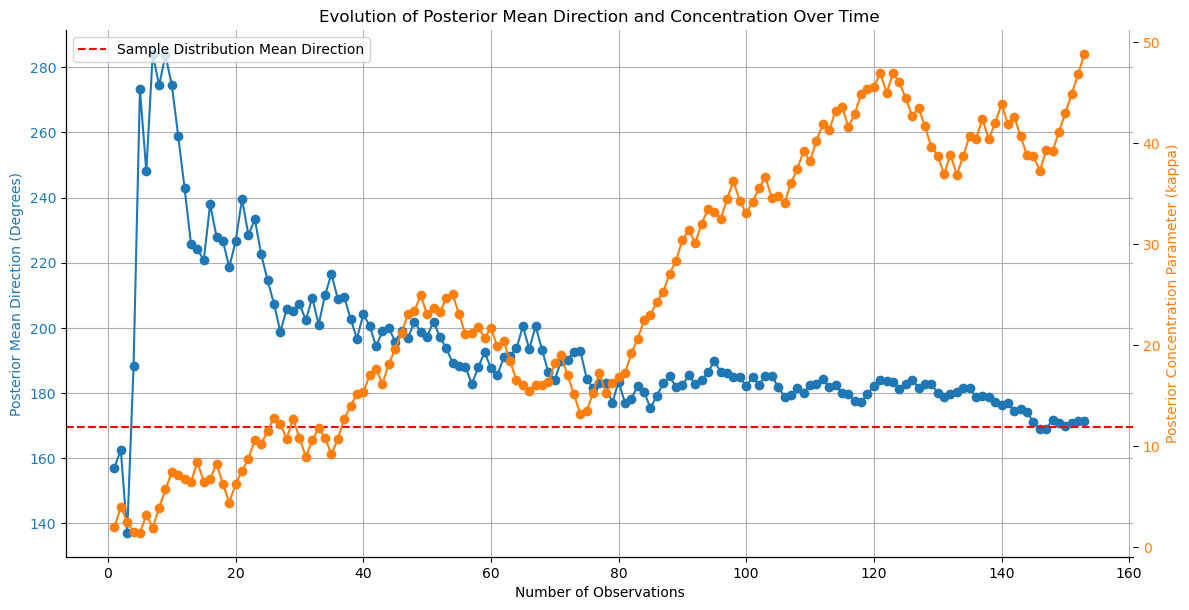

In [59]:
# Convert posterior_mus to degrees
posterior_mus_deg = np.rad2deg(posterior_mus) % 360
n_samples = data.shape[0]
true_mu = data['degrees'].mean()
# Plot evolution of posterior mean direction
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Observations')
ax1.set_ylabel('Posterior Mean Direction (Degrees)', color=color)
ax1.plot(range(1, n_samples + 1), posterior_mus_deg, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(true_mu, color='red', linestyle='--', label='Sample Distribution Mean Direction')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Posterior Concentration Parameter (kappa)', color=color)  # we already handled the x-label with ax1
ax2.plot(range(1, n_samples + 1), posterior_kappas, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
sns.despine()
plt.title('Evolution of Posterior Mean Direction and Concentration Over Time')
plt.show()

# PyMC3

# Unimodal South

In [10]:
# Calculate log likelihood for H0
log_likelihood_h0 = vonmises.logpdf(data['radians'], kappa=0, loc=0).sum()

with pm.Model() as model_uni:
    # Prior for kappa (using gamma as it's strictly positive)
    kappa = pm.HalfNormal('kappa', sigma=10)
    # Likelihood
    likelihood_h1 = pm.VonMises('angles', mu=np.pi, kappa=kappa, observed=data['radians'])
    # Compute log marginal likelihood for H1
    trace_uni = pm.sample(
        10000, tune=3000, chains=4, 
        return_inferencedata=True, 
        idata_kwargs={'log_likelihood': True})

# Calculate log likelihood for H1 using posterior samples
kappa_samples = trace_uni.posterior.kappa.values.flatten()

# Calculate log likelihood for each sample
log_likes = []
for k in kappa_samples:
    # Von Mises log likelihood
    log_like = vonmises.logpdf(data['radians'], k, loc=np.pi).sum()
    log_likes.append(log_like)

# Use log mean exp trick for numerical stability
log_likelihood_h1 = np.max(log_likes) + np.log(np.mean(np.exp(log_likes - np.max(log_likes))))

BF = np.exp(log_likelihood_h1 - log_likelihood_h0)
print(f"Bayes Factor: {BF:.4f}")
print(f"Probability kappa > 0.5: {np.mean(kappa_samples > 0.5):.4f}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 12 seconds.
There were 424 divergences after tuning. Increase `target_accept` or reparameterize.


Bayes Factor: 32.4645
Probability kappa > 0.5: 0.0649


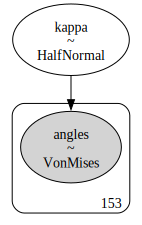

In [14]:
pm.model_to_graphviz(model_uni)

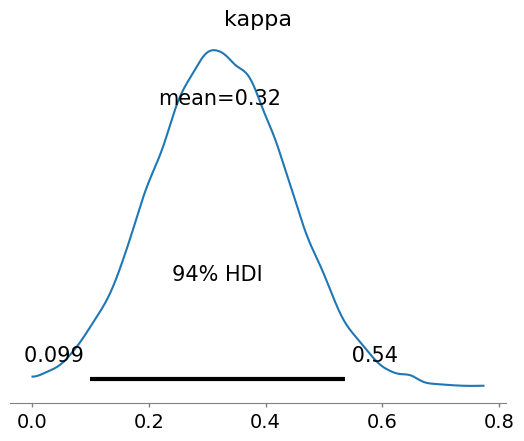

In [15]:
az.plot_posterior(trace_uni, var_names=['kappa'])
plt.show()

# Bimodal North-South Mixture model

In [16]:
# Type aliases
ArrayLike = Union[np.ndarray, pd.Series]
ResultDict = Dict[str, Union[float, InferenceData.InferenceData]]

In [17]:
def compute_mixture_vonmises_logpdf(
    series: ArrayLike,
    kappa: float,
    weights: npt.NDArray[np.float64],
    mus: List[float]
) -> float:
    """
    Compute log PDF for a mixture of von Mises distributions
    
    Parameters:
    -----------
    series: ArrayLike 
        Array of observed angles in radians
    kappa: float
        Concentration parameter
    weights: npt.NDArray[np.float64],
        Array of mixture weights
    mus: List[float] 
        Array of means for each component
    
    Returns:
    --------
    float: Sum of log probabilities for all data points
    """
    mixture_pdf = np.zeros_like(series)
    
    for w, mu in zip(weights, mus):
        mixture_pdf += w * vonmises.pdf(series, kappa, loc=mu)
    
    return np.log(np.maximum(mixture_pdf, 1e-300)).sum()

def compute_log_likelihoods(
    trace: az.InferenceData, 
    series: ArrayLike,
    mus: List[float]
    ) -> np.ndarray:
    """
    Compute log likelihoods for each sample in the trace

    Parameters:
    -----------
    trace: az.InferenceData
        The trace from the PyMC3 model sampling.

    series: ArrayLike
        Array of observed angles in radians
    
    """

    kappa_samples = trace.posterior.kappa.values.flatten()
    weights_samples = trace.posterior.weights.values.reshape(-1, 2)
    # Calculate log likelihood for each posterior sample
    log_likes = []
    for k, w in zip(kappa_samples, weights_samples):
        log_like = compute_mixture_vonmises_logpdf(
            series, 
            kappa=k, 
            weights=w, 
            mus=mus
        )
        log_likes.append(log_like)
    
    # Calculate marginal likelihood using log-sum-exp trick
    log_likelihood_h1 = np.max(log_likes) + np.log(np.mean(np.exp(log_likes - np.max(log_likes))))
    return log_likelihood_h1

def posterior_report(
    log_likelihood_h0: float, 
    log_likelihood_h1: float, 
    kappa_samples: ArrayLike,
    kappa_threshold: float = 0.5
    ) -> str:

    """
    Generate a report with Bayes Factor and probability kappa > threshold

    Parameters:
    -----------
    log_likelihood_h0: float
        Log likelihood for the null hypothesis
    log_likelihood_h1: float
        Log likelihood for the alternative hypothesis
    kappa_samples: ArrayLike
        Flattened posterior samples of the concentration parameter
    kappa_threshold: float
        Threshold for computing the probability that kappa > threshold

    Returns:
    --------
    summary: str
        A formatted string containing the summary statistics.
    """
    BF = np.exp(log_likelihood_h1 - log_likelihood_h0)

    summary = (
        f"Bayes Factor: {BF:.4f}\n"
        f"Probability kappa > {kappa_threshold}: {np.mean(kappa_samples > kappa_threshold):.4f}"
    )

    return summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, weights]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 28 seconds.


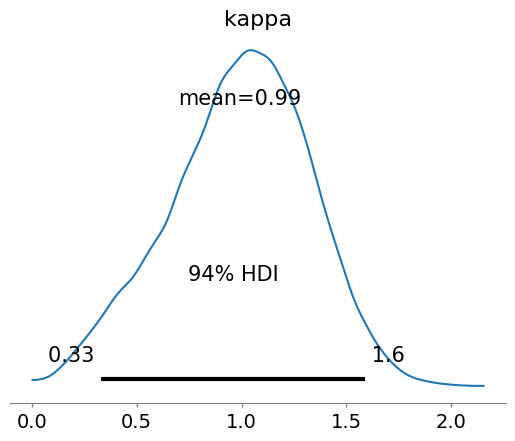

Bayes Factor: 214.2333
Probability kappa > 0.5: 0.9110


In [18]:
mu1 = 0            # 0 degrees
mu2 = np.pi        # 180 degrees

with pm.Model() as model_mixture_bimodal_NS:
    # Priors for concentration parameters
    kappa = pm.HalfNormal('kappa', sigma=10) 
    # Priors for component weights
    weights = pm.Dirichlet('weights', a=np.ones(2))
    
    # Define the von Mises components
    vm1 = pm.VonMises.dist(mu=mu1, kappa=kappa)
    vm2 = pm.VonMises.dist(mu=mu2, kappa=kappa)
    
    # Mixture distribution
    likelihood = pm.Mixture(
        'angles',
        w=weights,
        comp_dists=[vm1, vm2],
        observed=data['radians']
    )
    
    # Sample from the posterior
    trace_mixture_bimodal_NS = pm.sample(
        10000, tune=3000, chains=4, return_inferencedata=True, idata_kwargs={'log_likelihood': True})
    
    # Get kappa samples
    kappa_samples = trace_mixture_bimodal_NS.posterior.kappa.values.flatten()

# Posterior Analysis
az.plot_posterior(trace_mixture_bimodal_NS, var_names=['kappa'])
plt.show()

log_likelihood_h1 = compute_log_likelihoods(trace_mixture_bimodal_NS, data['radians'], [mu1, mu2])
print(posterior_report(log_likelihood_h0, log_likelihood_h1, kappa_samples))

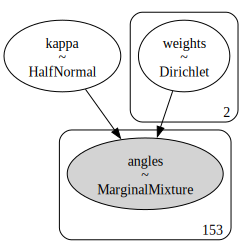

In [19]:
pm.model_to_graphviz(model_mixture_bimodal_NS)

# Bimodal West-South Mixture Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, weights]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 28 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


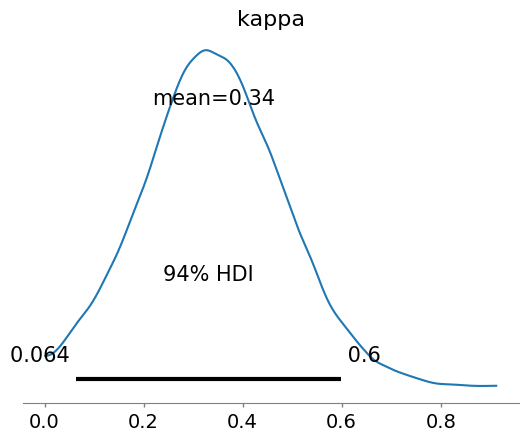

Bayes Factor: 20.2361
Probability kappa > 0.5: 0.1329


In [20]:
mu1 = np.pi          # 180 degrees
mu2 = 3 * np.pi / 2  # 270 degrees

with pm.Model() as model_mixture_bimodal_WS:
    # Priors for concentration parameters
    kappa = pm.HalfNormal('kappa', sigma=10)
    
    # Priors for component weights
    weights = pm.Dirichlet('weights', a=np.ones(2))
    
    # Define the four von Mises components
    vm1 = pm.VonMises.dist(mu=mu1, kappa=kappa)
    vm2 = pm.VonMises.dist(mu=mu2, kappa=kappa)
    
    # Mixture distribution
    likelihood = pm.Mixture(
        'angles',
        w=weights,
        comp_dists=[vm1, vm2],
        observed=data['radians']
    )
    
    # Sample from the posterior
    trace_mixture_bimodal_WS = pm.sample(
        10000, tune=3000, chains=4, return_inferencedata=True, idata_kwargs={'log_likelihood': True})
    
    # Get kappa samples
    kappa_samples = trace_mixture_bimodal_WS.posterior.kappa.values.flatten()

# Posterior Analysis
az.plot_posterior(trace_mixture_bimodal_WS, var_names=['kappa'])
plt.show()

log_likelihood_h1 = compute_log_likelihoods(trace_mixture_bimodal_WS, data['radians'], [mu1, mu2])
print(posterior_report(log_likelihood_h0, log_likelihood_h1, kappa_samples))


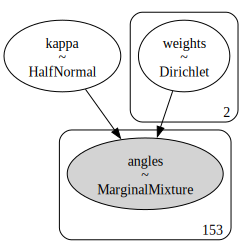

In [21]:
pm.model_to_graphviz(model_mixture_bimodal_WS)

# Quadri-modal Mixture Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, weights]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 48 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


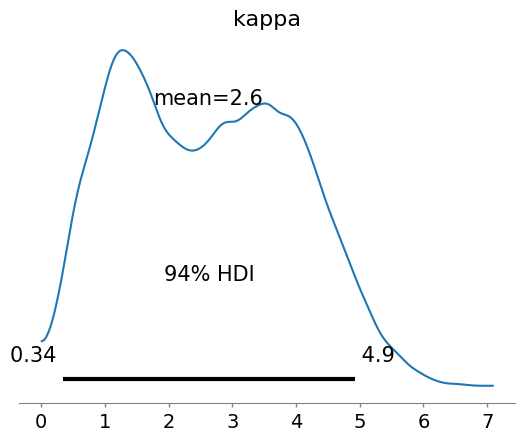

Bayes Factor: 0.0000
Probability kappa > 0.5: 0.9644


In [22]:

mu1 = 0            # 0 degrees
mu2 = np.pi / 2    # 90 degrees
mu3 = np.pi        # 180 degrees
mu4 = 3 * np.pi / 2  # 270 degrees

with pm.Model() as model_mixture_quad:
    # Priors for concentration parameters
    kappa = pm.HalfNormal('kappa', sigma=10)
    
    # Priors for component weights
    weights = pm.Dirichlet('weights', a=np.ones(4))
    
    # Define the four von Mises components
    vm1 = pm.VonMises.dist(mu=mu1, kappa=kappa)
    vm2 = pm.VonMises.dist(mu=mu2, kappa=kappa)
    vm3 = pm.VonMises.dist(mu=mu3, kappa=kappa)
    vm4 = pm.VonMises.dist(mu=mu4, kappa=kappa)
    
    # Mixture distribution
    likelihood = pm.Mixture(
        'angles',
        w=weights,
        comp_dists=[vm1, vm2, vm3, vm4],
        observed=data['radians']
    )
    
    # Sample from the posterior
    trace_mixture_quad = pm.sample(
        10000, tune=3000, chains=4, return_inferencedata=True, idata_kwargs={'log_likelihood': True}
    )

    # Get kappa samples
    kappa_samples = trace_mixture_quad.posterior.kappa.values.flatten()

# Posterior Analysis
az.plot_posterior(trace_mixture_quad, var_names=['kappa'])
plt.show()

log_likelihood_h1 = compute_log_likelihoods(trace_mixture_quad, data['radians'], [mu1, mu2, mu3, mu4])
print(posterior_report(log_likelihood_h0, log_likelihood_h1, kappa_samples))

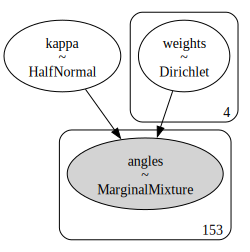

In [23]:
pm.model_to_graphviz(model_mixture_quad)

# WAIC comparison

In [42]:
# Compute WAIC for each model
wail_uni = az.waic(trace_uni)
waic_quad = az.waic(trace_mixture_quad)
waic_bimodal_NS = az.waic(trace_mixture_bimodal_NS)
waic_bimodal_WS = az.waic(trace_mixture_bimodal_WS)

model_dict = {
    'Quadrimodal Model': trace_mixture_quad,
    'Bimodal Model (NS)': trace_mixture_bimodal_NS,
    'Bimodal Model (WS)': trace_mixture_bimodal_WS,
    'Unimodal Model': trace_uni 
}

# Compare models using WAIC
waic_comparison = az.compare(model_dict, ic='waic')
waic_comparison

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Bimodal Model (NS),0,-277.242401,2.146095,0.000000,8.320809e-01,3.273840,0.000000,False,log
Quadrimodal Model,1,-278.098738,4.282122,0.856337,2.254672e-17,3.297694,1.154299,False,log
Unimodal Model,2,-278.407868,1.101017,1.165467,1.679191e-01,2.955619,1.872642,False,log
Bimodal Model (WS),3,-279.277623,1.473369,2.035222,5.551115e-16,2.574516,1.947494,False,log


In [43]:
# Compare models using LOO
loo_comparison = az.compare(model_dict, ic='loo')
loo_comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Bimodal Model (NS),0,-277.242743,2.146437,0.000000,8.321053e-01,3.273835,0.000000,False,log
Quadrimodal Model,1,-278.099952,4.283337,0.857209,1.500559e-17,3.297736,1.154273,False,log
Unimodal Model,2,-278.408323,1.101472,1.165580,1.678947e-01,2.955624,1.872663,False,log
Bimodal Model (WS),3,-279.277712,1.473458,2.034968,0.000000e+00,2.574525,1.947468,False,log


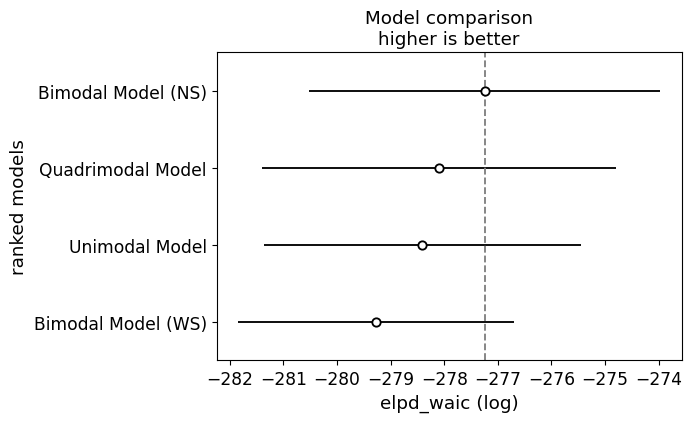

In [44]:
# Visualize the comparison
az.plot_compare(waic_comparison)
plt.show()

In [48]:
model_dict = {
    'Quadrimodal Model': (model_mixture_quad, trace_mixture_quad),
    'Bimodal Model (NS)': (model_mixture_bimodal_NS, trace_mixture_bimodal_NS),
    'Bimodal Model (WS)': (model_mixture_bimodal_WS, trace_mixture_bimodal_WS),
    'Unimodal Model': (model_uni, trace_uni)
}

ppc_results = {}

# Perform PPCs for each model
for model_name, (model, trace) in model_dict.items():
    with model:
        ppc = pm.sample_posterior_predictive(trace, var_names=['angles'])
    ppc_angles_deg = ppc['posterior_predictive']['angles'].values
    # Store the PPC results
    ppc_results[model_name] = ppc_angles_deg

Sampling: [angles]


Sampling: [angles]


Sampling: [angles]


Sampling: [angles]


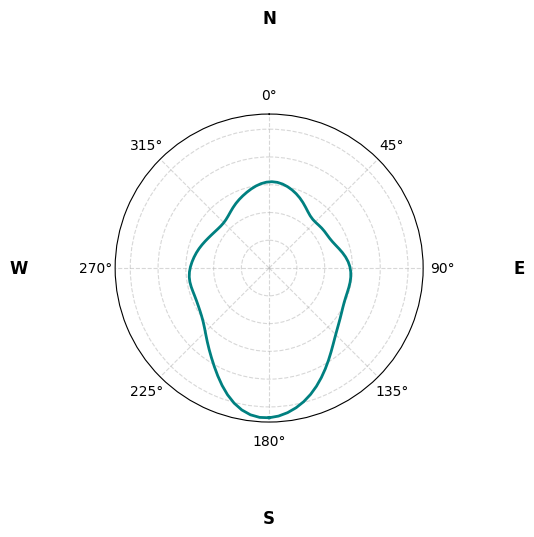

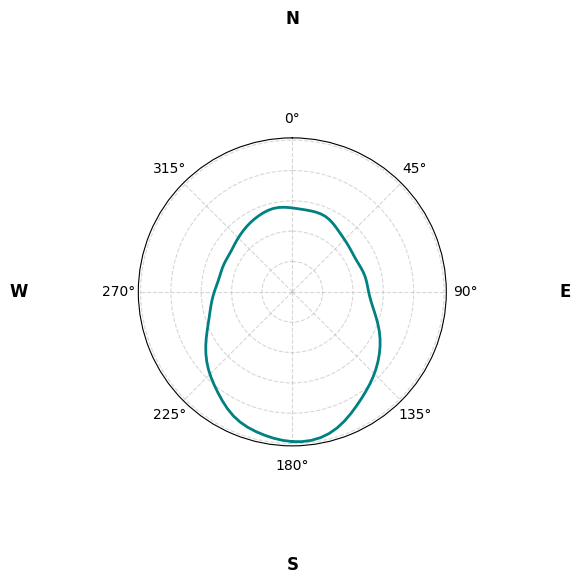

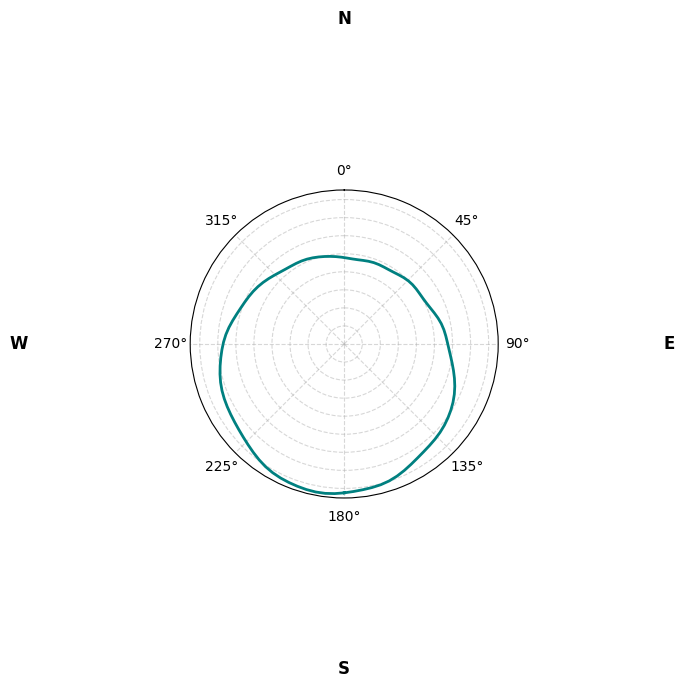

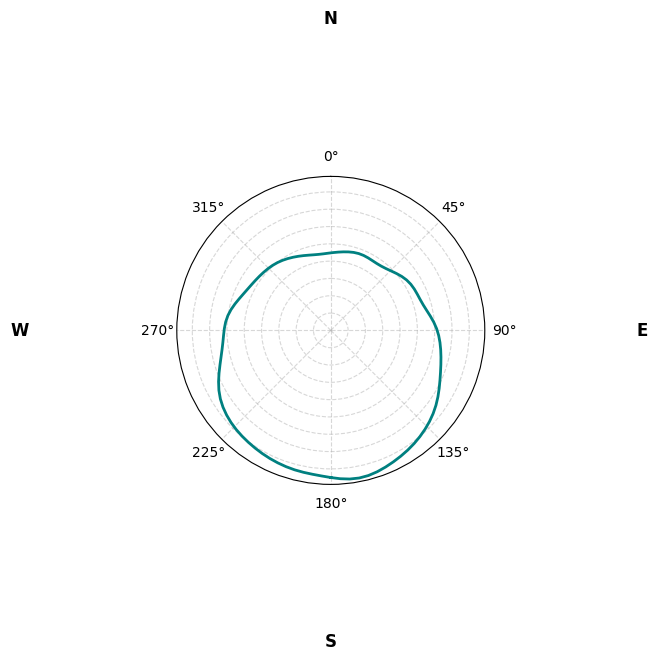

<Figure size 640x480 with 0 Axes>

In [49]:
# converting angles to degrees to plot on the compass
ppc_results_deg = {model_name: np.rad2deg(ppc) % 360 for model_name, ppc in ppc_results.items()}

# Plot the PPC results
for model_name, ppc_angles in ppc_results_deg.items():
    # Create a DataFrame for the PPC angles
    ppc_df = pd.DataFrame({'degrees': ppc_angles.reshape(-1)}).sample(50000)
    ppc_df['radians'] = convert_angles(ppc_df['degrees'], low=0, high=360)
    
    # Plot the circular distribution
    plot_circular_distribution(
        ppc_df, 
        plot_type='kde', 
        bins=48, 
        color='teal',
        edgecolor='black'
        )

plt.tight_layout()
plt.show()
